In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
# from pylab import *
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import math


import random
import logging
import os
from datetime import datetime
import numpy as np

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
g = torch.Generator()
g.manual_seed(0)

In [29]:

if not os.path.exists("logs"):
    os.mkdir("logs")
logging.basicConfig(filename='logs/prompting_log.log', format='%(asctime)s %(message)s', level=logging.INFO)

In [46]:
# ImageNet transformer
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

# Generated data transformer
data_transform = transforms.Compose([
        transforms.RandAugment(magnitude=15),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

In [42]:
batch_size = 32
num_classes = 10

In [43]:

classes = ['airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

label_list = ['airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [47]:
train_set = datasets.ImageFolder(root='/hdd2/srinath/dataset_augmentation_diffusers/train_images/', transform=data_transform)    
# train_set = datasets.ImageFolder(root='../Dreambooth-Stable-Diffusion/generated_images/', transform=data_transform)    
trainset_size = math.ceil(len(train_set) * 0.85)
trainset, traintestset = random_split(train_set, [math.ceil(len(train_set) * 0.85), math.floor(len(train_set) * 0.15)])  

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
traintestsetloader = torch.utils.data.DataLoader(traintestset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

logging.info('Train set: generated')

testset = datasets.ImageFolder(root='/hdd2/srinath/Imge_net_images', transform=transform)
# testset = torchvision.datasets.CIFAR10(root='CIFAR_10/original/images', train=False,
#                                       download=True, transform=transform)

print("TrainSet, Validation Set, Test Set ", len(trainset), len(traintestset), len(testset))


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
logging.info('Test set: ImageNet')

TrainSet, Validation Set, Test Set  8512 1502 13958


torch.Size([10, 3, 256, 256])
7


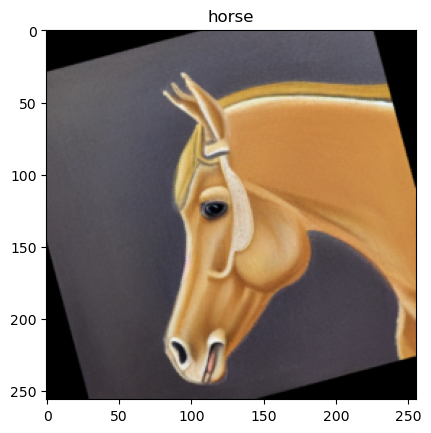

2


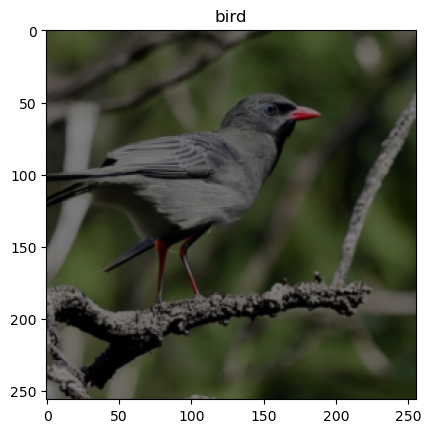

2


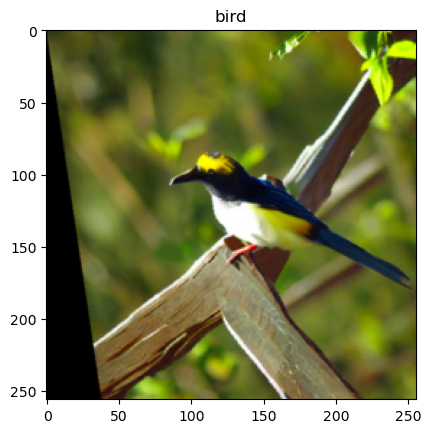

6


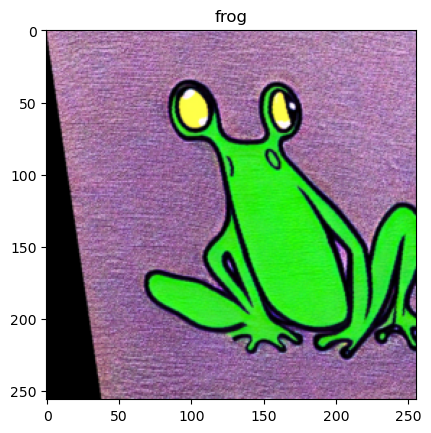

4


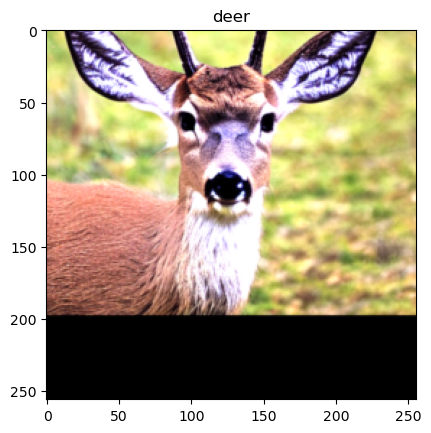

2


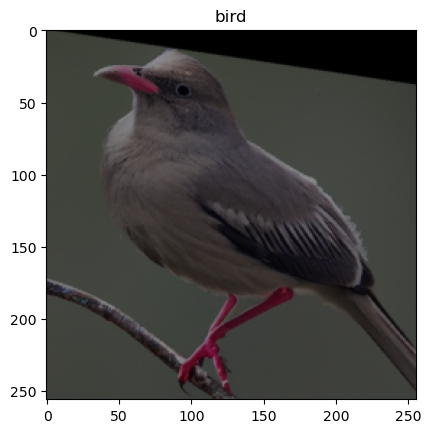

8


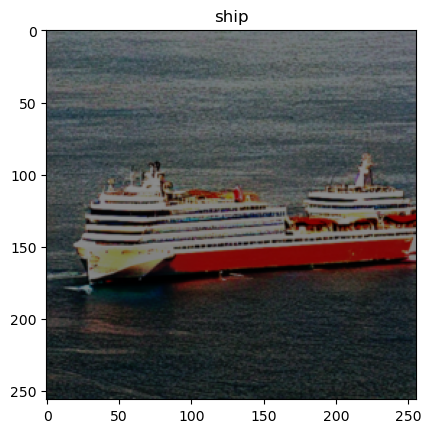

6


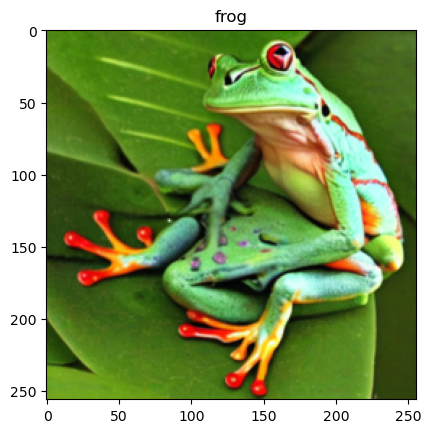

1


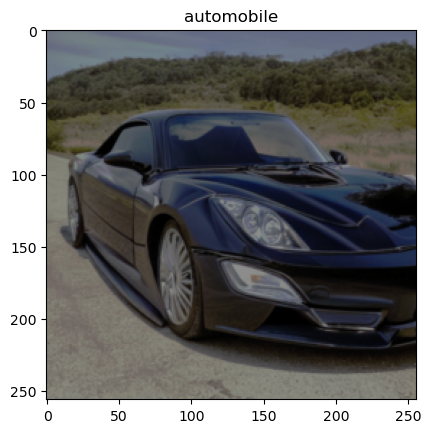

1


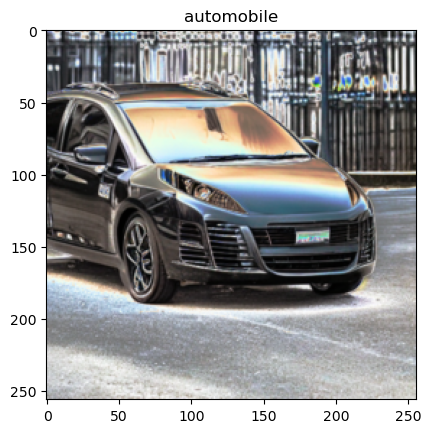

In [48]:
for data in trainloader:
    inputs, labels = data[0], data[1]
    print(inputs.shape)
    for _i, _l in zip(inputs, labels):
        print(_l.item())
        plt.imshow(_i.permute(1, 2, 0))
        plt.title(classes[_l.item()])
        plt.show()
    
    break

torch.Size([10, 3, 256, 256])
horse


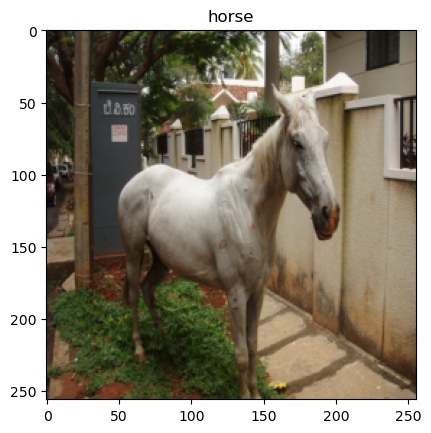

deer


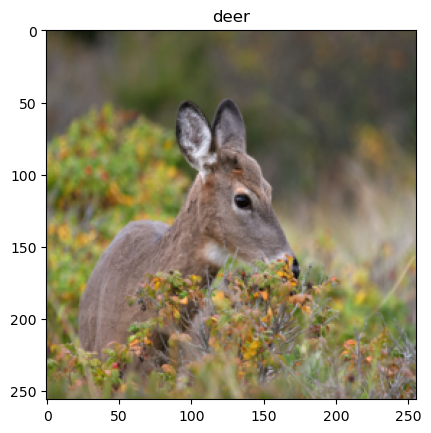

automobile


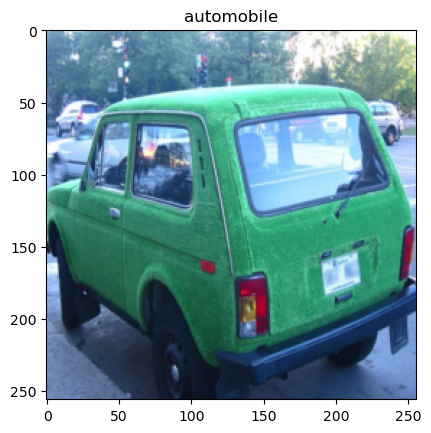

dog


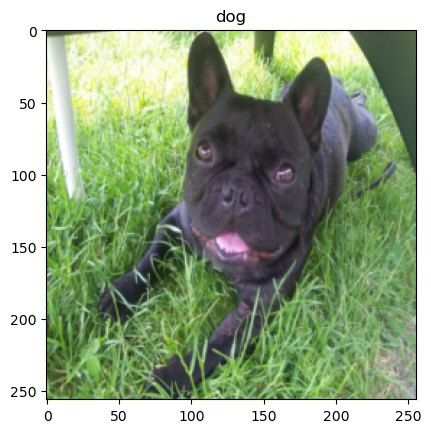

automobile


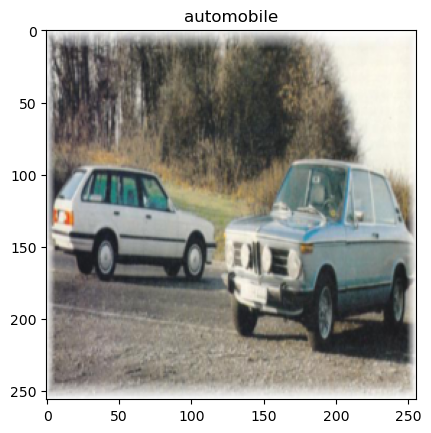

airplane


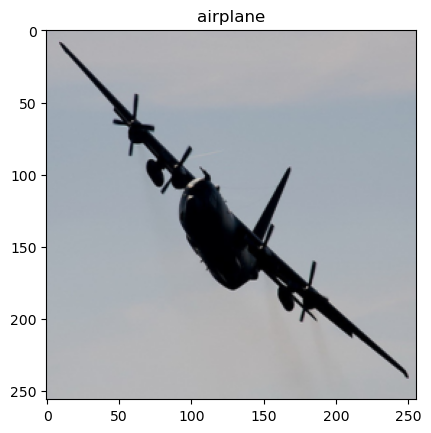

horse


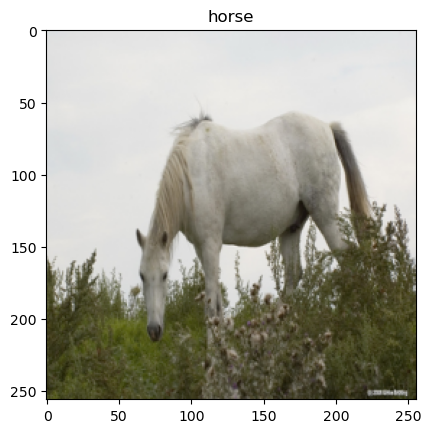

dog


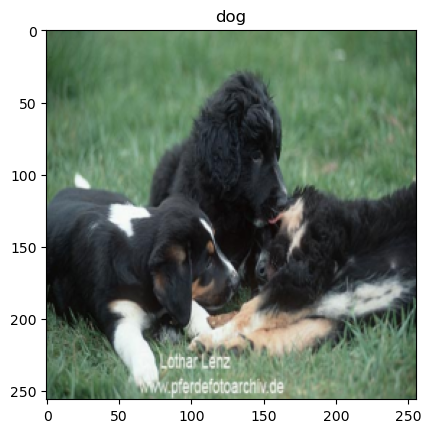

truck


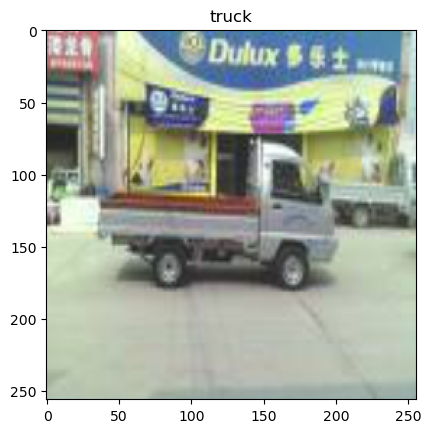

deer


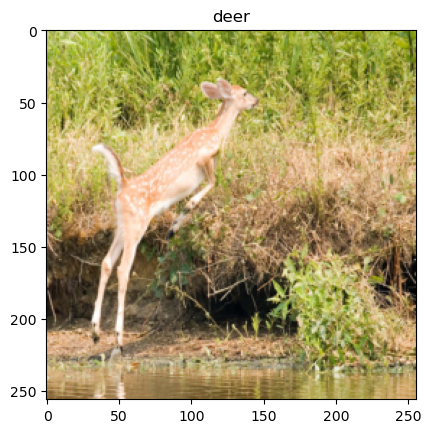

In [38]:
for data in testloader:
    inputs, labels = data[0], data[1]
    print(inputs.shape)
    for _i, _l in zip(inputs, labels):
        print(classes[_l.item()])
        plt.imshow(_i.permute(1, 2, 0))
        plt.title(classes[_l.item()])
        plt.show()
    break

In [8]:

def train(net, train_loader):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    print(net.parameters())
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    num_batches = trainset_size // batch_size

    for epoch in range(5):  # loop over the dataset multiple times

        correct = 0
        total = 0
        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):

            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # print label
            # print(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            if i == (num_batches-1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
                logging.info(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
                running_loss = 0.0
                _, predicted = torch.max(outputs.data.cuda(), 1)
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum().item()
                print(f'Accuracy: {100 * correct // total} %')
                logging.info(f'Accuracy: {100 * correct // total} %')

    print('Finished Training')
    logging.info('Finished Training')

    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
    PATH = './ImageNet_'+ str(len(train_set)) + dt_string + '.pth'
    torch.save(net.state_dict(), PATH)

In [9]:

def TEST(net, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.cuda())
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data.cuda(), 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')
    logging.info(f'Accuracy of the network on the test images: {100 * correct // total} %')

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images.cuda())
            _, predictions = torch.max(outputs.cuda(), 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label.cuda() == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
        logging.info(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [10]:

# We will just finetune (so won't pass gradient to back)
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

feature_extract = True
set_parameter_requires_grad(model, feature_extract)
model.fc = nn.Linear(512, num_classes)

model = model.to('cuda')

params_to_update = model.parameters()

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Using cache found in /home/srinath/.cache/torch/hub/pytorch_vision_v0.10.0


Params to learn:
	 fc.weight
	 fc.bias


In [13]:

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train(model, trainloader)

<generator object Module.parameters at 0x7fab355b93f0>
[1,   266] loss: 0.218
Accuracy: 100 %


KeyboardInterrupt: 

In [ ]:

print("Test on Generated Test set:")
logging.info("Test on Generated test set:")
TEST(model, traintestsetloader)

In [ ]:

print("Test on ImageNet test set:")
logging.info("Test on ImageNet test set:")
TEST(model, testloader)